#1. Setting up Environment

In [1]:
! pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# 2. Import Dataset and Check it

In [5]:
# Load the Fashion MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
print("Data shape", X_train.shape)

Data shape (60000, 28, 28)


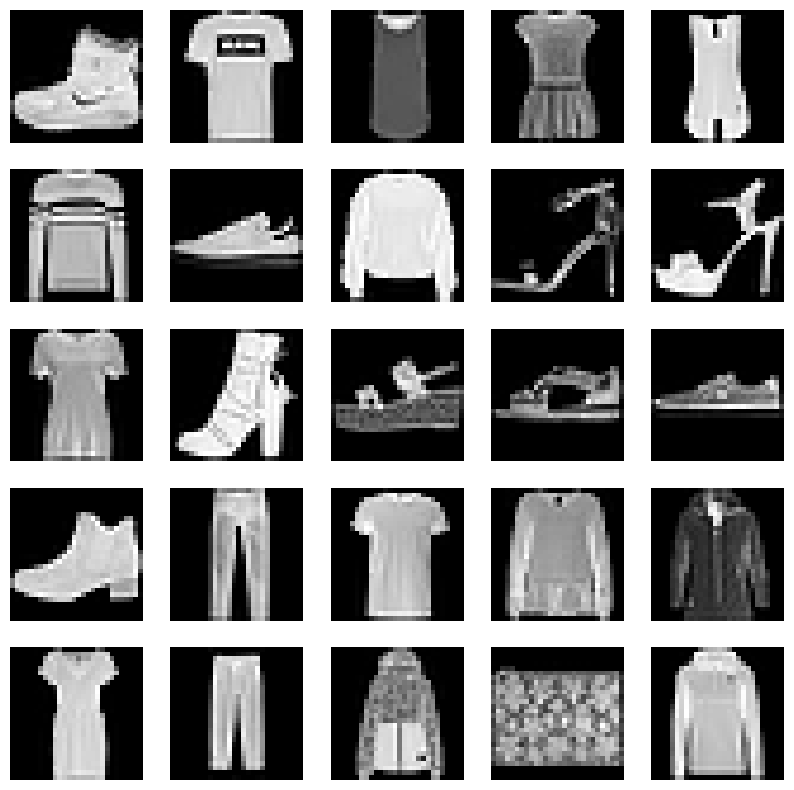

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")
plt.show()

# 3. Create a Data Pipeline

In [8]:
X_train.shape[0]

60000

In [9]:
# Normalize and reshape the data
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')
X_train = (X_train  - 127.5) / 127.5

In [10]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

In [11]:
# create the tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

# 4. Create a Discriminator and a Generator

In [13]:
def build_generator():
  model = keras.Sequential([
      layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Reshape((7,7,256)),

      layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),

      layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False, activation = 'tanh'),
      layers.BatchNormalization(),
      layers.LeakyReLU(0.2),

      layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation = 'tanh')
  ])
  return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
cross_entropy = keras.losses.BinaryCrossentropy()

**Create the generator and discriminator losses**

In [24]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #ccalculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss

In [25]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

**Building a Sub class model**

In [27]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [28]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

# 5. Train the Dataset

In [29]:
EPOCH = 100

In [30]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3437 - g_loss: 0.7609

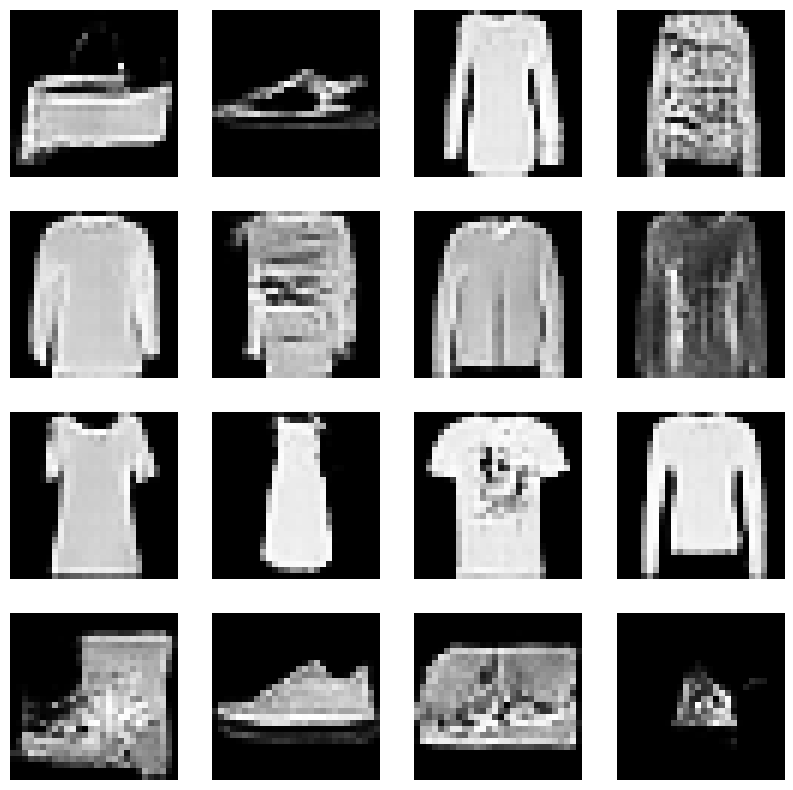

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3440 - g_loss: 0.7603
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3440 - g_loss: 0.7626
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3431 - g_loss: 0.7584
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3438 - g_loss: 0.7653
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3442 - g_loss: 0.7647
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3418 - g_loss: 0.7627

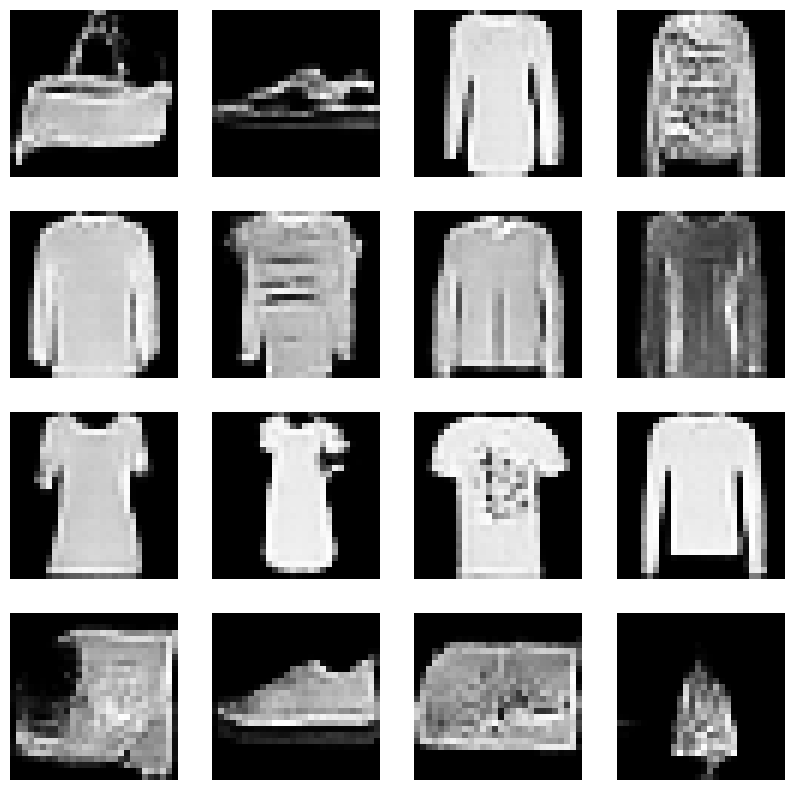

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3419 - g_loss: 0.7617
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3420 - g_loss: 0.7607
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3404 - g_loss: 0.7616
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3431 - g_loss: 0.7618
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3413 - g_loss: 0.7589
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3403 - g_loss: 0.7637

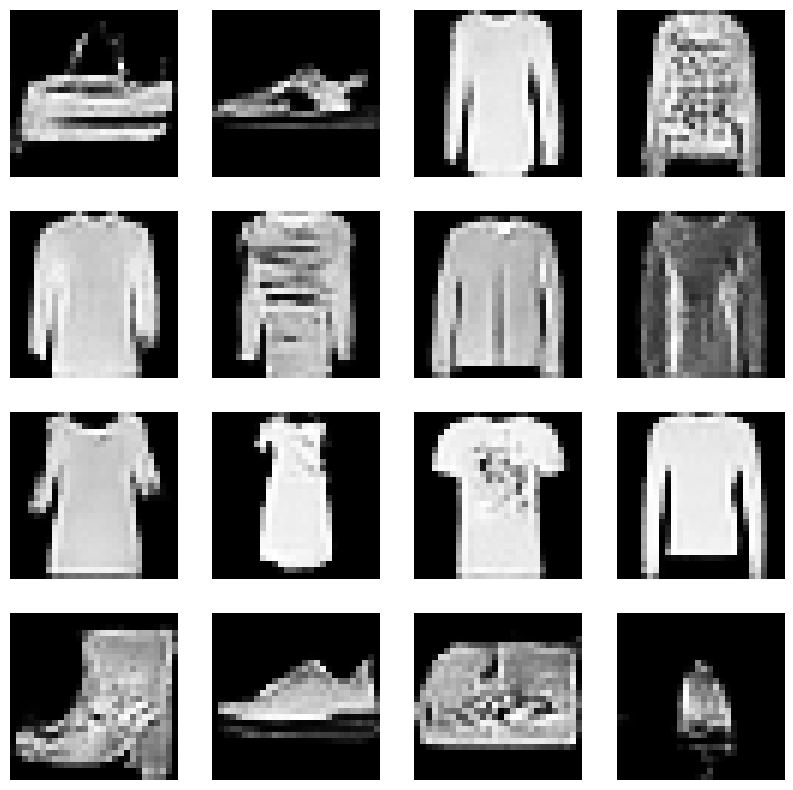

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3402 - g_loss: 0.7635
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3401 - g_loss: 0.7615
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3417 - g_loss: 0.7667
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3410 - g_loss: 0.7647
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3402 - g_loss: 0.7651
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3387 - g_loss: 0.7601

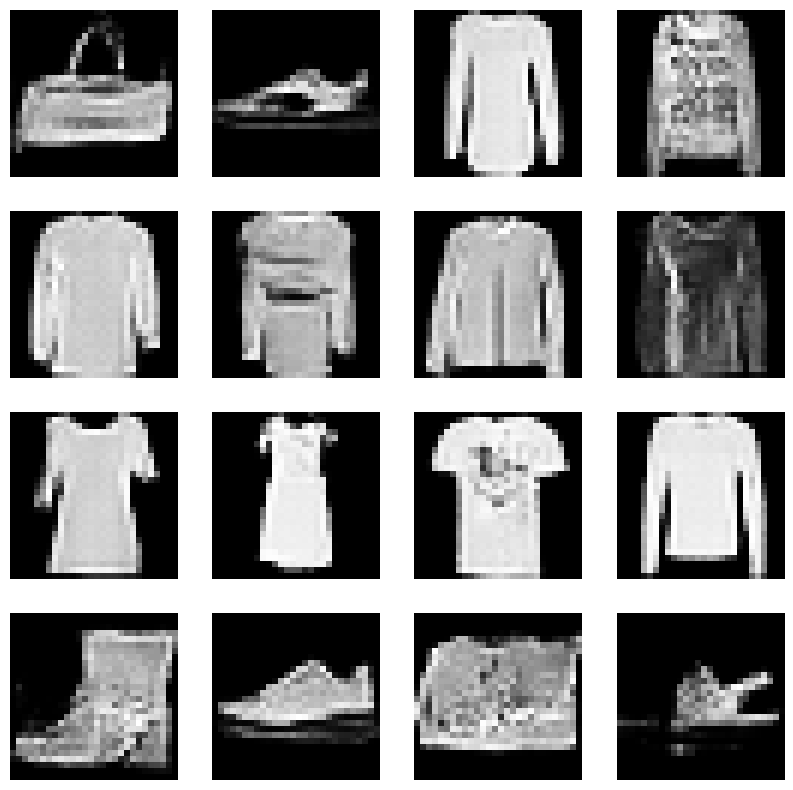

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3387 - g_loss: 0.7603
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3396 - g_loss: 0.7607
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3396 - g_loss: 0.7634
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3392 - g_loss: 0.7657
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3391 - g_loss: 0.7629
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3379 - g_loss: 0.7646

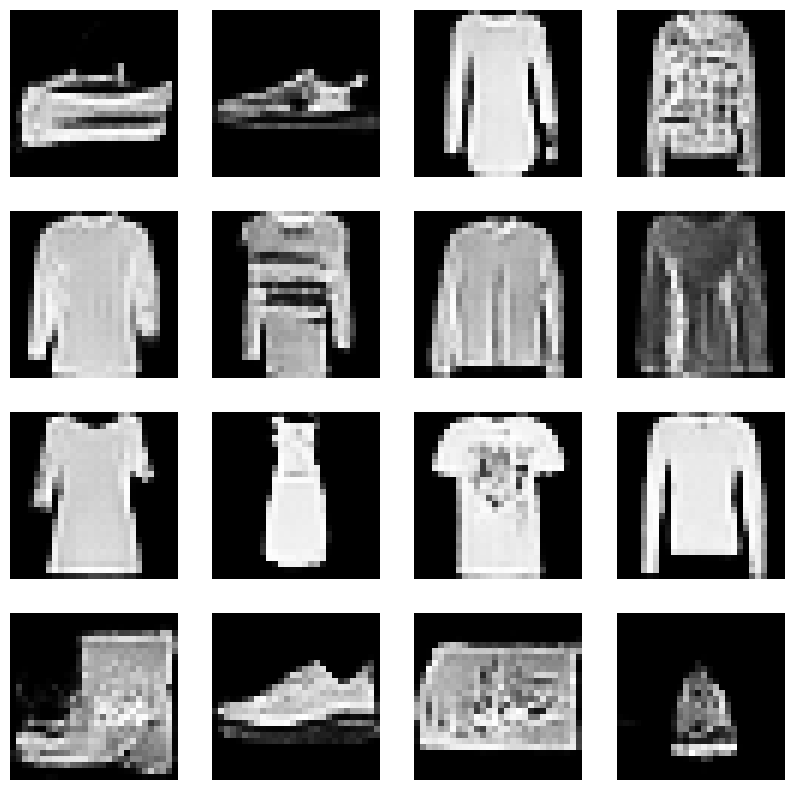

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3379 - g_loss: 0.7642
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3397 - g_loss: 0.7669
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3374 - g_loss: 0.7622
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3391 - g_loss: 0.7712
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3378 - g_loss: 0.7669
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3383 - g_loss: 0.7666

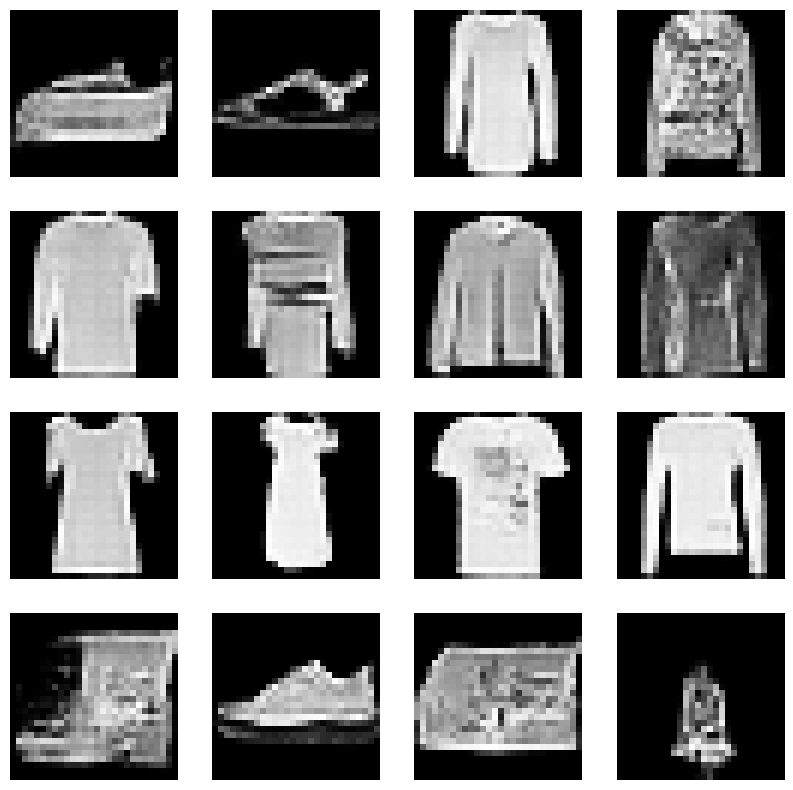

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3381 - g_loss: 0.7666
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3366 - g_loss: 0.7652
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3379 - g_loss: 0.7663
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3376 - g_loss: 0.7693
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3365 - g_loss: 0.7671
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3352 - g_loss: 0.7652

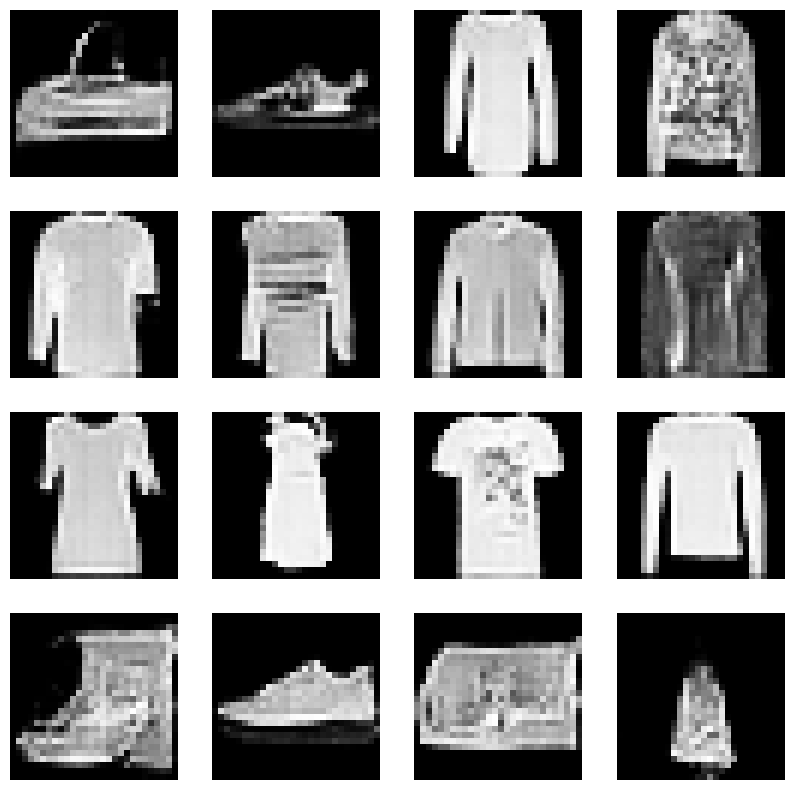

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3354 - g_loss: 0.7661
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3348 - g_loss: 0.7647
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3367 - g_loss: 0.7731
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3366 - g_loss: 0.7668
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3362 - g_loss: 0.7697
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3360 - g_loss: 0.7692

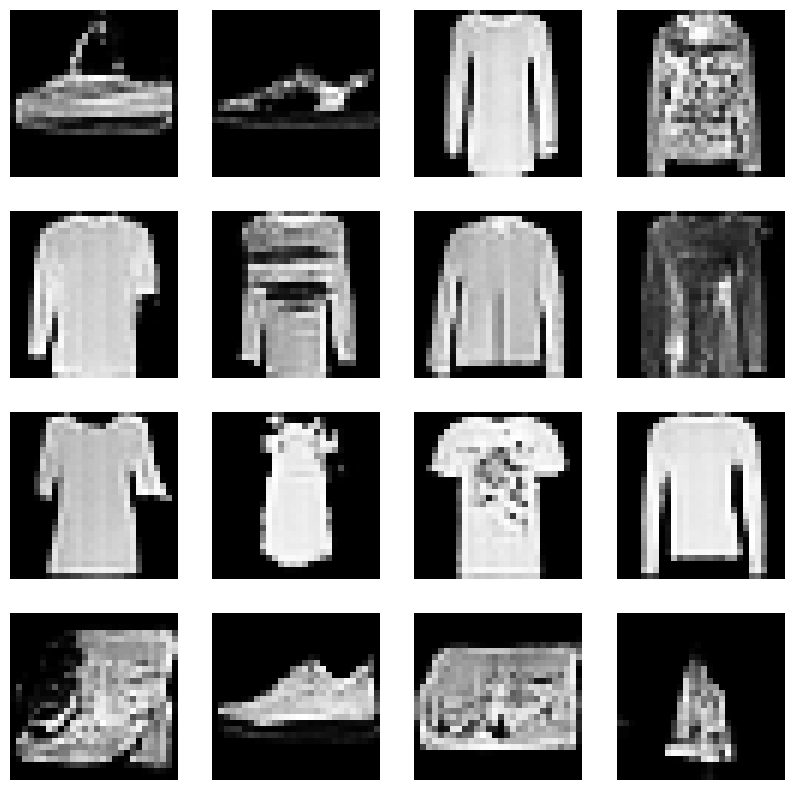

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3360 - g_loss: 0.7691
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3346 - g_loss: 0.7731
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3341 - g_loss: 0.7718
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3348 - g_loss: 0.7677
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3334 - g_loss: 0.7734
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3344 - g_loss: 0.7726

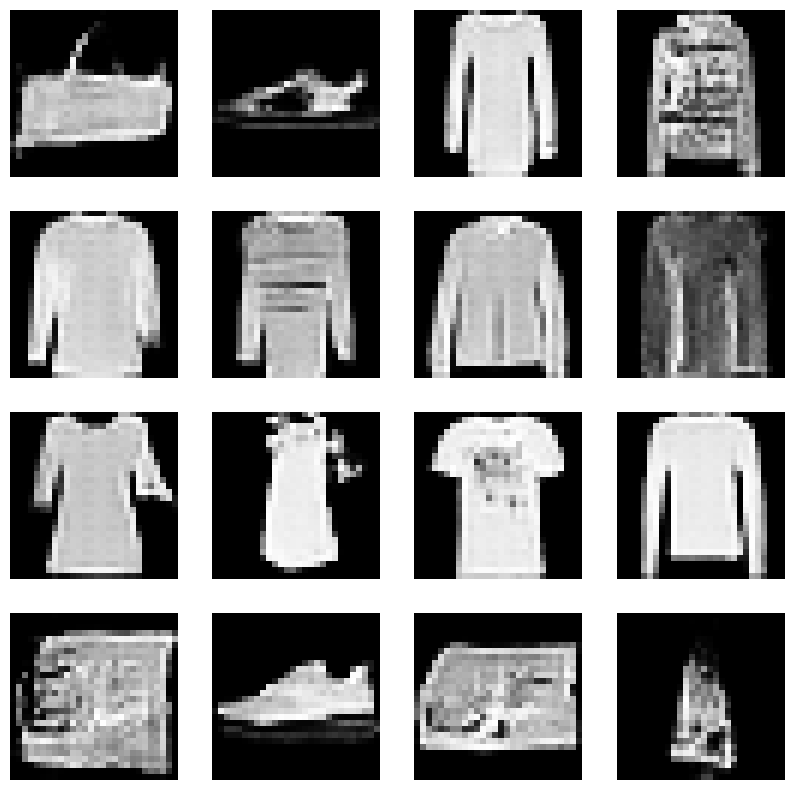

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3342 - g_loss: 0.7725
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3336 - g_loss: 0.7738
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3317 - g_loss: 0.7717
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3331 - g_loss: 0.7679
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3351 - g_loss: 0.7718
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3313 - g_loss: 0.7711

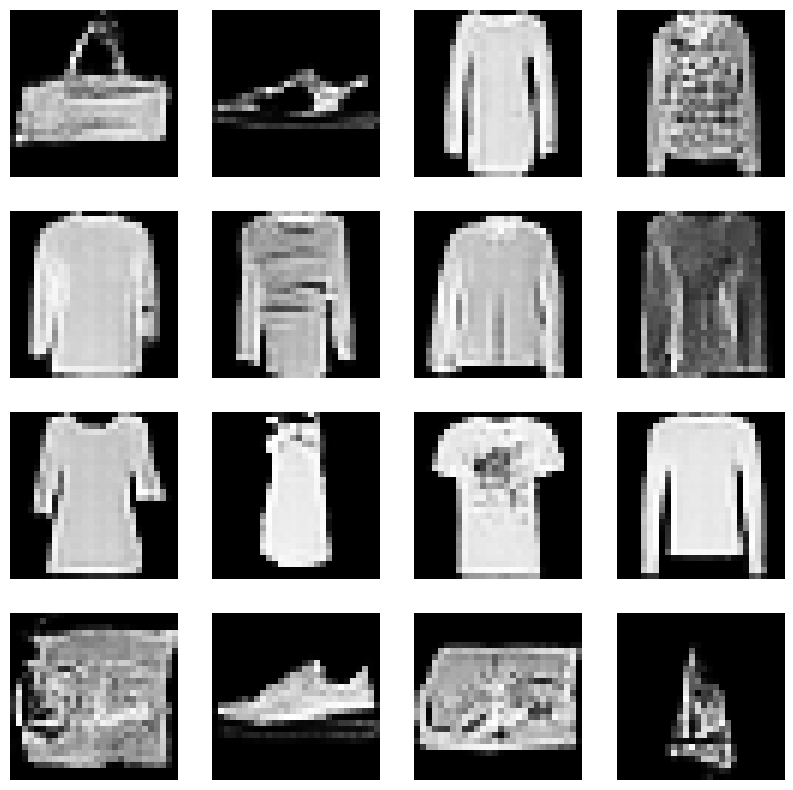

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3314 - g_loss: 0.7712
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3328 - g_loss: 0.7707
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3316 - g_loss: 0.7758
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3311 - g_loss: 0.7742
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3314 - g_loss: 0.7747
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3332 - g_loss: 0.7775

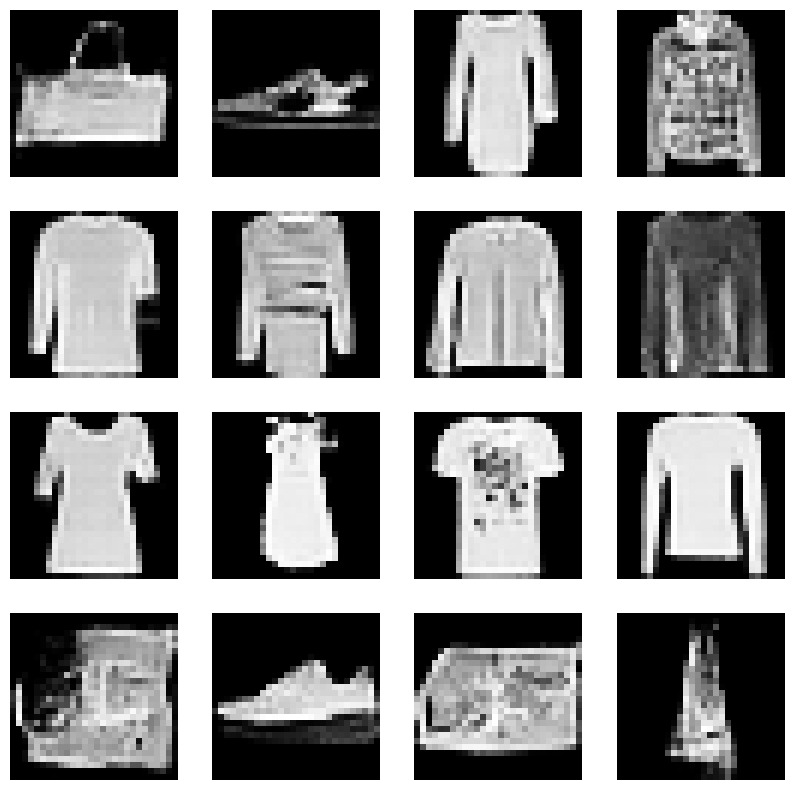

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3334 - g_loss: 0.7775
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3311 - g_loss: 0.7731
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3311 - g_loss: 0.7747
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3296 - g_loss: 0.7738
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3288 - g_loss: 0.7685
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3307 - g_loss: 0.7761

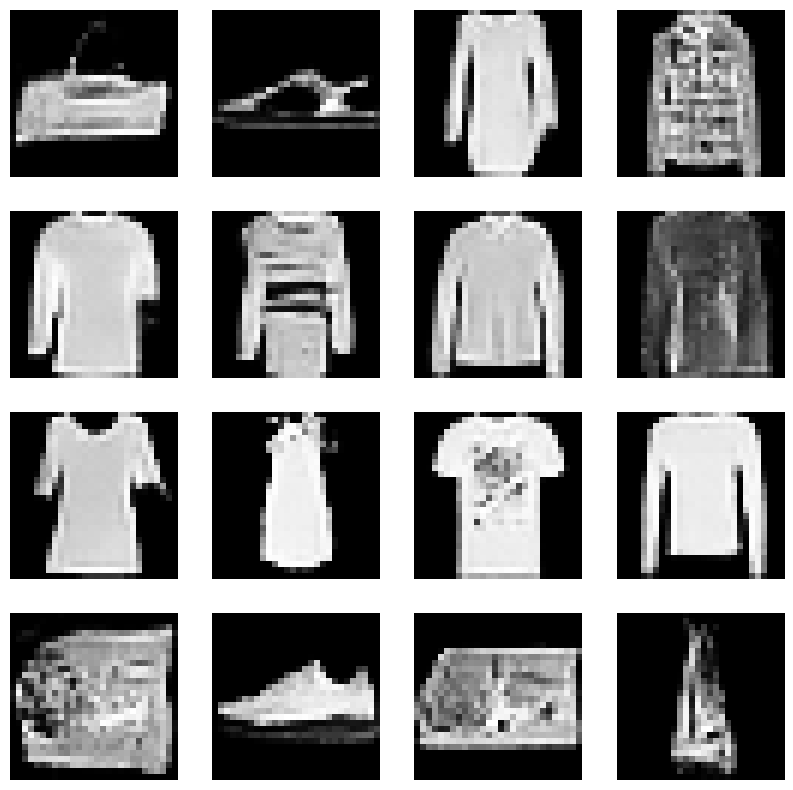

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3306 - g_loss: 0.7764
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3290 - g_loss: 0.7741
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3296 - g_loss: 0.7770
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3279 - g_loss: 0.7776
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3292 - g_loss: 0.7815
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.3267 - g_loss: 0.7765

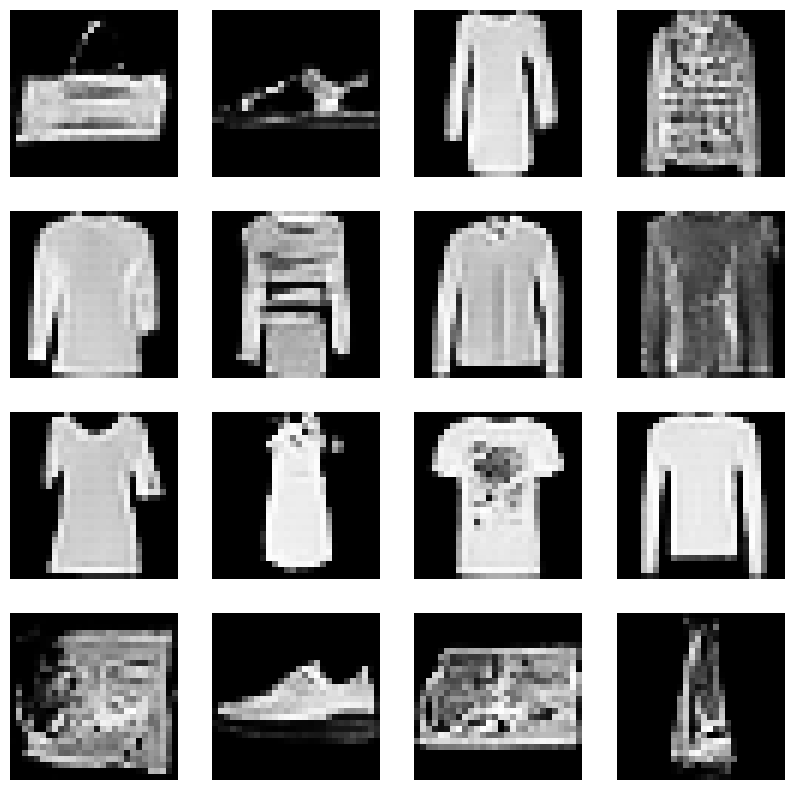

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3264 - g_loss: 0.7754
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3291 - g_loss: 0.7769
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3292 - g_loss: 0.7782
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3266 - g_loss: 0.7751
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3279 - g_loss: 0.7778
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3306 - g_loss: 0.7781

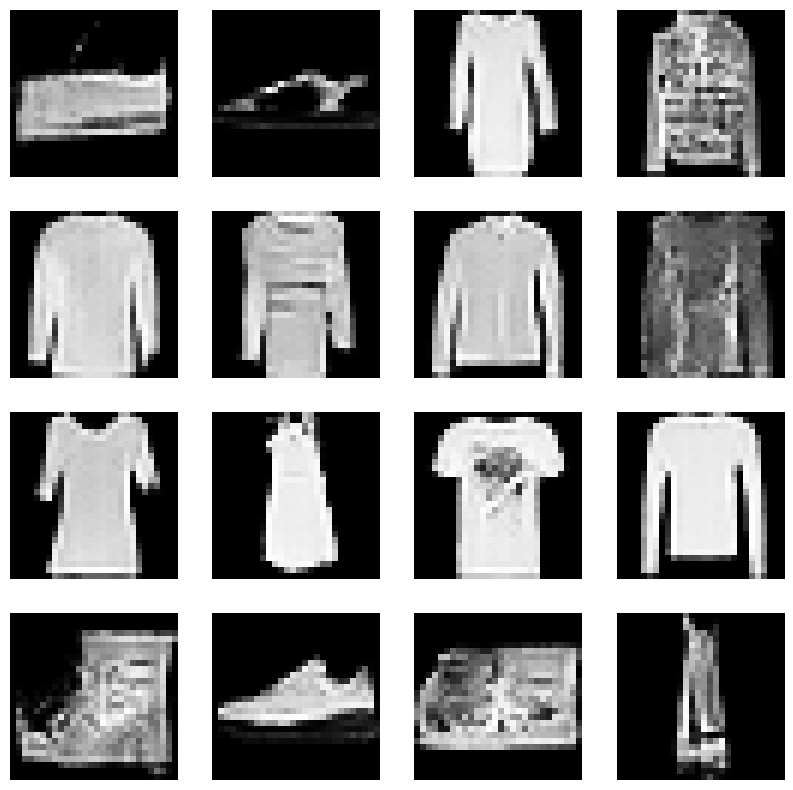

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3304 - g_loss: 0.7781
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3273 - g_loss: 0.7786
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3272 - g_loss: 0.7800
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3259 - g_loss: 0.7815
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3264 - g_loss: 0.7808
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3276 - g_loss: 0.7839

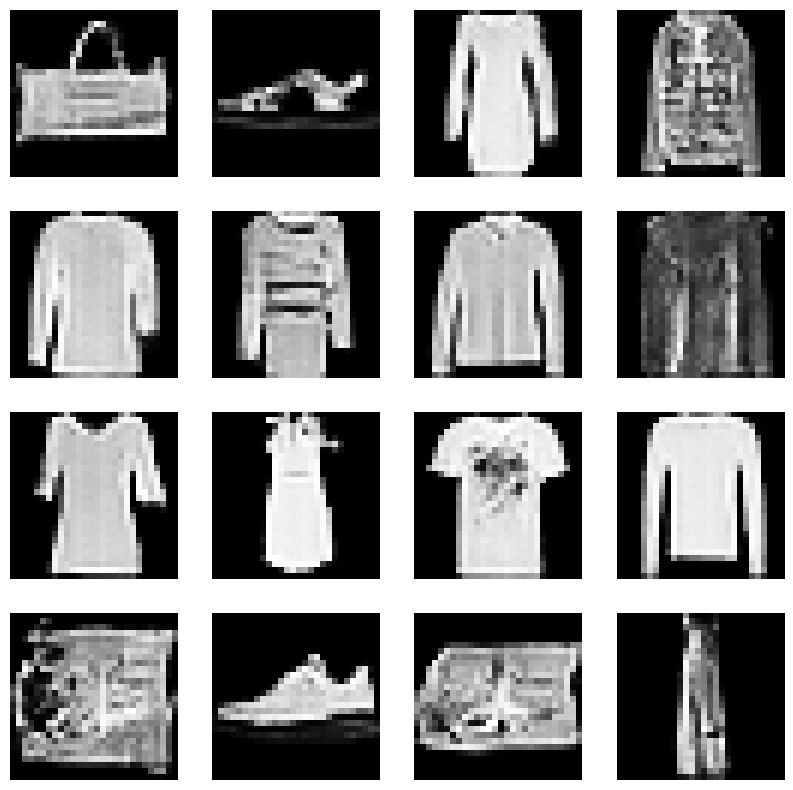

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3277 - g_loss: 0.7838
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3250 - g_loss: 0.7763
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3251 - g_loss: 0.7813
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3242 - g_loss: 0.7826
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3256 - g_loss: 0.7834
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3252 - g_loss: 0.7798

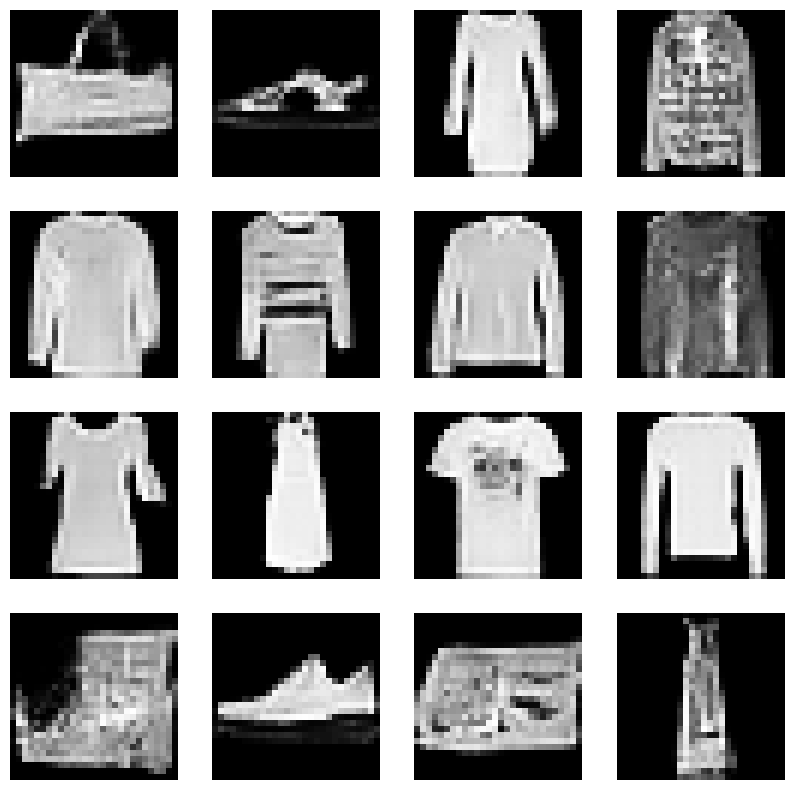

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3253 - g_loss: 0.7795
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3249 - g_loss: 0.7832
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3234 - g_loss: 0.7809
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3238 - g_loss: 0.7800
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3238 - g_loss: 0.7841
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3242 - g_loss: 0.7853

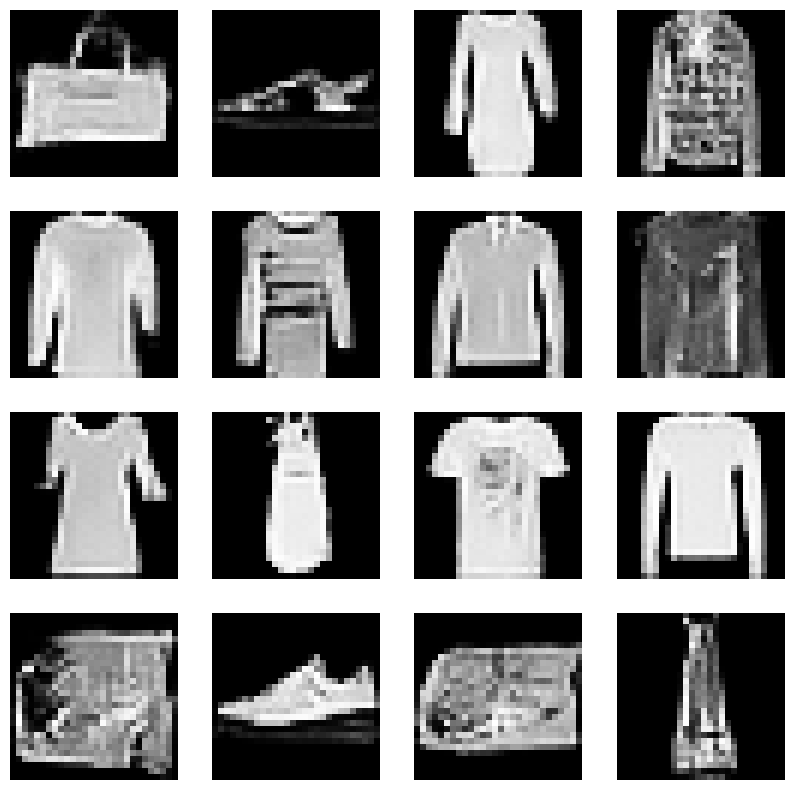

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3238 - g_loss: 0.7861
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3227 - g_loss: 0.7823
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3238 - g_loss: 0.7822
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3238 - g_loss: 0.7889
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3203 - g_loss: 0.7839
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3222 - g_loss: 0.7879

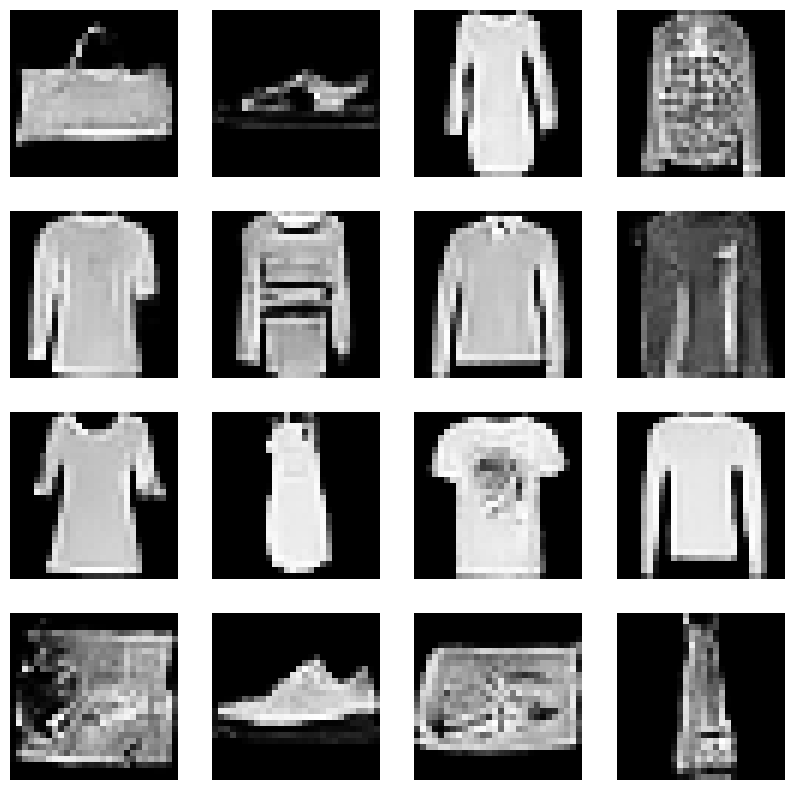

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3221 - g_loss: 0.7881
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3213 - g_loss: 0.7829
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3212 - g_loss: 0.7868
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3205 - g_loss: 0.7831
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3201 - g_loss: 0.7864
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3210 - g_loss: 0.7875

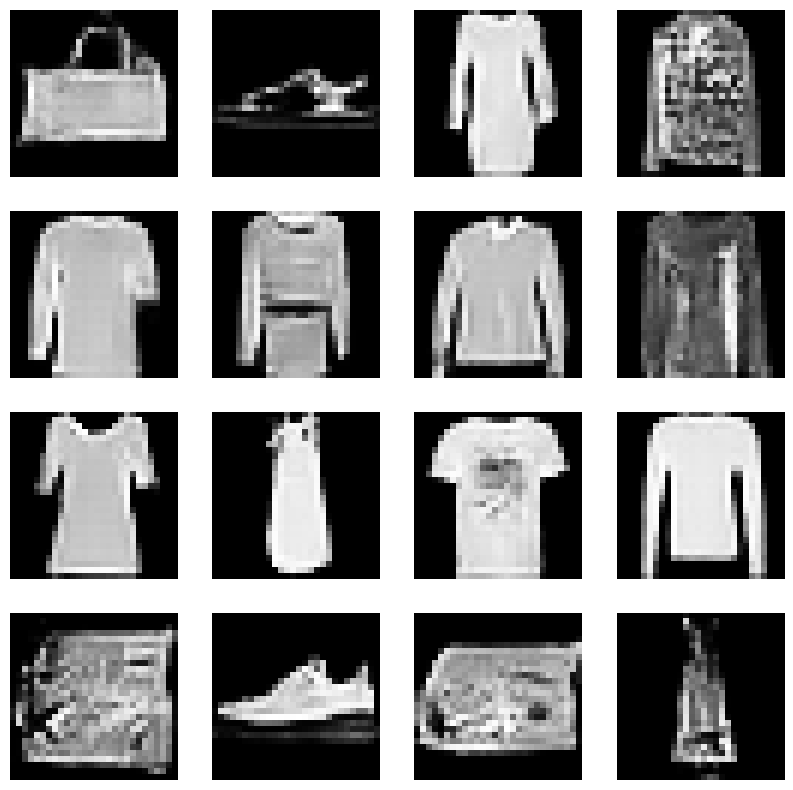

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3210 - g_loss: 0.7872
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3195 - g_loss: 0.7856
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3176 - g_loss: 0.7855
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3191 - g_loss: 0.7909
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3191 - g_loss: 0.7867
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3176 - g_loss: 0.7908

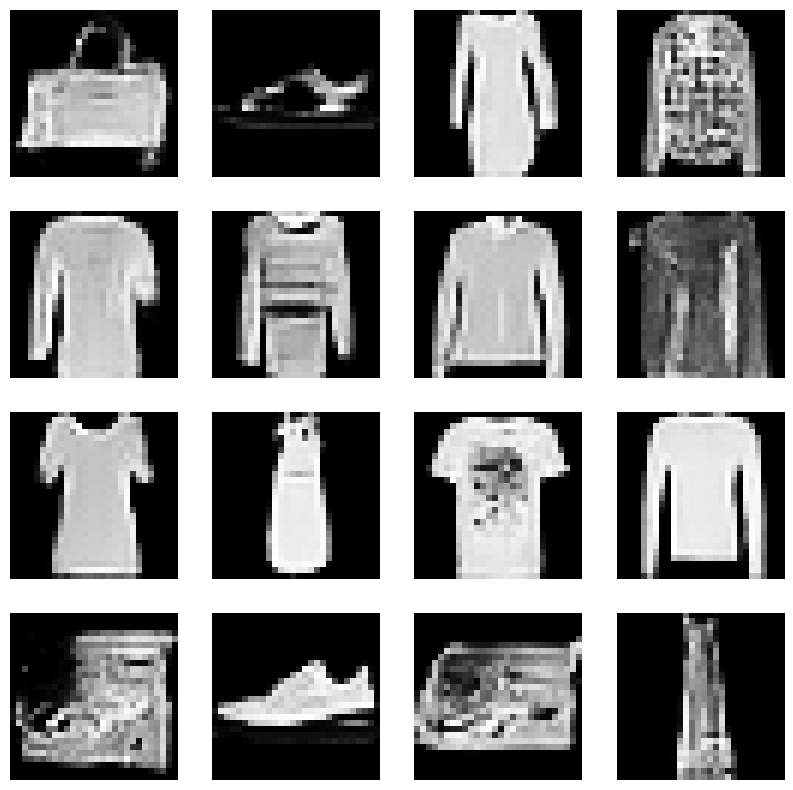

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3173 - g_loss: 0.7913
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3175 - g_loss: 0.7901
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3168 - g_loss: 0.7876
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3186 - g_loss: 0.7921
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3166 - g_loss: 0.7874


In [32]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

# 6. Evaluate the model

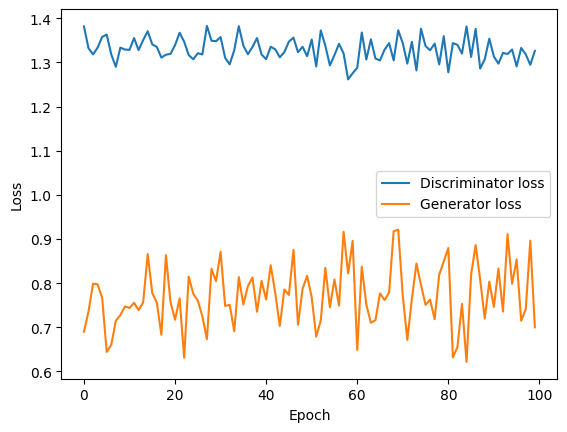

In [33]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

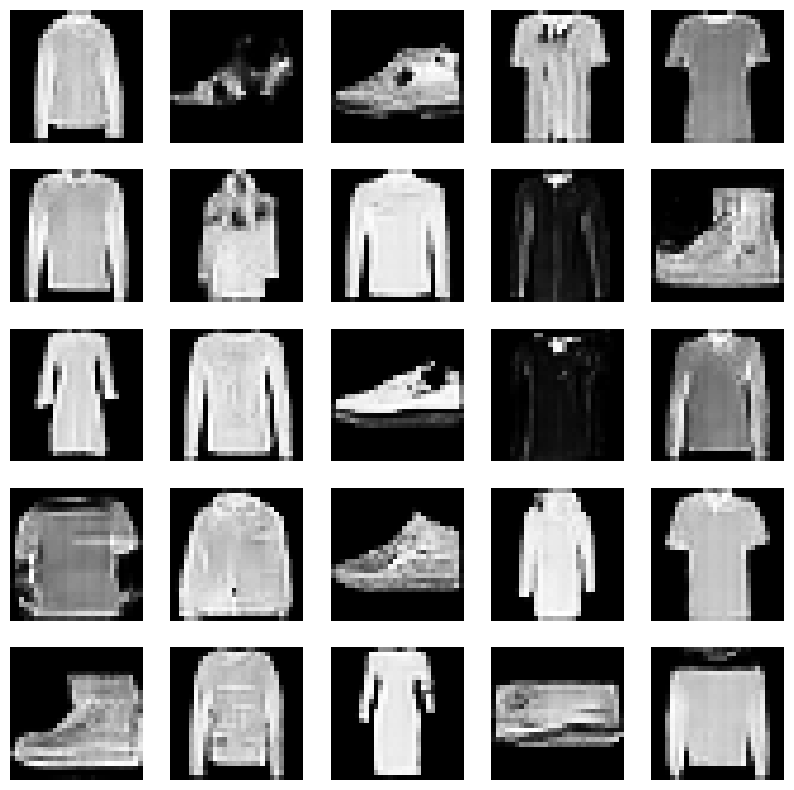

In [35]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt.show()

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
generator.save("/content/drive/My Drive/fashion_gan_generator.h5")